In [2]:
import numpy as np
import pandas as pd

import cmcrameri.cm as cm
import matplotlib.pyplot as plt 
from scipy.stats import normaltest, mannwhitneyu, ttest_ind

In [3]:
### Latex font in plots
plt.rcParams['font.serif'] = "cmr10"
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.size'] = 24

plt.rcParams['legend.fontsize'] = 24
plt.rcParams['legend.loc'] = 'upper right'
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams["axes.grid"] = False
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['axes.linewidth'] = 4   # Default for all spines
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
# plt.rcParams['text.usetex'] = True
plt.rcParams['xtick.major.size'] = 6  # Thicker major x-ticks
plt.rcParams['xtick.major.width'] = 2  # Thicker major x-
plt.rcParams['ytick.major.size'] = 6  
plt.rcParams['ytick.major.width'] = 2 
plt.rc('axes', unicode_minus=False)


In [4]:
def load_data(data_path, data_file):
    # load data from csv
    df = pd.read_csv(path.join(data_path, data_file))
    return df

def compute_profit_eps(df):
    # compute profit per episode
    N = (df[df['episode'] == 0]).shape[0]
    profits_per_episode = df[['Profits', 'episode']].groupby('episode').sum().reset_index()
    return profits_per_episode


def aggregate_data(df: pd.DataFrame, column: str) -> pd.DataFrame:
    """
    Function that computes statistics for violations and profits per episode.
    This function takes in a DataFrame and the name of the column to be used for violations.

    Args:
    - df: the DataFrame
    - column: the name of the column to be used for violations

    Returns:
    - episode: the episode number
    - Profits: the total profits for the episode
    - CO2 Violation Time (%): the percentage of time with CO2 violations
    - CO2 Violation (ppm): the average magnitude of CO2 violations
    """
    # print(df)
    N = (df[df['episode'] == 0]).shape[0]
    profits_per_episode = df[['Profits', 'episode']].groupby('episode').sum().reset_index()
    # CO2 violation time per episode, considering each row as 5 minutes
    co2_violation_time_updated = df[df[column] > 0].groupby('episode').size()/N*100 # % of time with violation
    # print(co2_violation_time_updated)
    # co2_violation_time_updated = 100-co2_violation_time_updated
    # print(co2_violation_time_updated)
    # Average magnitude of CO2 violations per episode, for positive violations only
    # avg_co2_violation_magnitude_updated = df[[column, 'episode']].groupby('episode')[column].sum()
    avg_co2_violation_magnitude_updated = df[df[column] > 0].groupby('episode')[column].mean()
    # Combine the updated results into a summary DataFrame
    summary_df_updated = pd.DataFrame({
        f'Time within boundary (%)': co2_violation_time_updated,
        f'{column} (abs)': avg_co2_violation_magnitude_updated,
    }).reset_index()

    # add coefficient to resulting 

    # Create a DataFrame of all unique episodes to ensure all are represented
    all_episodes_df = pd.DataFrame(df['episode'].unique(), columns=['episode'])

    # Merge the summary of violations with the complete list of episodes
    # This ensures episodes with no violations are included, filling missing values appropriately
    full_summary_df = pd.merge(all_episodes_df, summary_df_updated, on='episode', how='left').fillna(0)
    # print(full_summary_df['coefficients'])
    full_summary_df = pd.merge(profits_per_episode, full_summary_df, on='episode', how='left').fillna(0)
    full_summary_df['Time within boundary (%)'] = 100- full_summary_df['Time within boundary (%)']
    return full_summary_df

def calculate_twb(dataframes, labels):
    twb_df = pd.DataFrame()
    twb_df_ci = pd.DataFrame()
    N = dataframes[0]['episode'].unique().shape[0]
    for j, df in enumerate(dataframes):
        vars = ['CO2 violation', 'Temperature violation', 'Humidity violation']
        violations = [aggregate_data(df, var) for var in vars]

        twb = np.array([violations[i]['Time within boundary (%)'].mean() for i in range(len(vars))])
        df_twb = pd.DataFrame({labels[j]: twb,}, index=vars)
        twb_df = pd.concat([twb_df, df_twb], axis=1)
        
        cis = [ci(violations[i]['Time within boundary (%)'].std(), N) for i in range(len(vars))]
        df_twb_ci = pd.DataFrame({labels[j]: cis,}, index=vars)
        twb_df_ci = pd.concat([twb_df_ci, df_twb_ci], axis=1)
    return twb_df.T, twb_df_ci.T



def ci(std, n, z=2.576):
    return z*std/np.sqrt(n)

In [5]:
def generate_barplots(dataframes, xlabels, colors):
    fig, ax = plt.subplots(dpi=120)
    n = dataframes[0].shape[0]  # Assuming all dataframes have the same shape
    # colors = [cm.tokyoS(4+i) for i in range(len(dataframes))]
    heights = []
    errors = []
    for i, df in enumerate(dataframes):
        heights.append(df['Profits'].mean())
        errors.append(ci(df['Profits'].std(), n))
    print(heights, errors)
    # ax = ax[i] if len(dataframes) > 1 else axes
    ax.set_ylabel(r'$r_{0:N}^{\mathrm{profit}}$')
    ax.bar(xlabels, heights, width=0.6, color=colors, edgecolor='black')
    ax.errorbar(xlabels, heights, yerr=errors, capsize=5, linestyle='None', color='black', fmt='')

    fig.tight_layout()
    fig.savefig('profits.svg') 
    plt.show()



In [6]:
def generate_grouped_bar_plot(twb_df, twb_df_ci, xlabels, colors):
    co2color = cm.tokyoS(4)
    tcolor = cm.tokyoS(9)
    humcolor = cm.tokyoS(6)

    fig, ax = plt.subplots(dpi=120)

    index = np.arange(len(xlabels))

    bar_width = 0.2

    bars1 = ax.bar(index - bar_width, twb_df['CO2 violation'], bar_width, edgecolor='black', color=co2color, label=r'CO$_2$')
    ax.errorbar(index - bar_width, twb_df['CO2 violation'], yerr=twb_df_ci["CO2 violation"], capsize=5, linestyle='None', color='black', fmt='')

    bars2 = ax.bar(index, twb_df['Temperature violation'], bar_width, edgecolor='black', color=tcolor, label='Temperature')
    ax.errorbar(index, twb_df['Temperature violation'], yerr=twb_df_ci["Temperature violation"], capsize=5, linestyle='None', color='black', fmt='')

    bars3 = ax.bar(index + bar_width, twb_df['Humidity violation'], bar_width, edgecolor='black', color=humcolor, label='Humidity')
    ax.errorbar(index + bar_width, twb_df['Humidity violation'], yerr=twb_df_ci["Humidity violation"], capsize=5, linestyle='None', color='black', fmt='')

    ax.set_xticks(index)
    ax.set_xticklabels(xlabels)
    ax.set_ylabel('Time within boundary (%)')
    ax.legend()
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    fig.tight_layout()
    fig.savefig('twb.svg')
    plt.show()


In [7]:
def plot_avg_day(df, variable, fig, ax, label, linestyle, color, cumsum=False):
    Ndays = 600
    time_step_means = df.groupby('TimeOfDay')[variable].mean().reset_index()
    # time_step_stds = df.groupby('TimeOfDay')[variable].var().reset_index()
    time_step_ci = ci(df.groupby('TimeOfDay')[variable].std().values, Ndays)
    # Convert 'TimeOfDay' to minutes past midnight for plotting
    time_step_means['MinutesPastMidnight'] = time_step_means['TimeOfDay'].apply(lambda t: t.hour + t.minute/60)
    time_step_means['MinutesPastMidnight'] 
    
    # Plotting with the modified time format
    
    if cumsum:
        time_step_means[variable] = time_step_means[variable].cumsum()
        print(time_step_means[variable].iloc[-1])
        time_step_ci
    ax.plot(time_step_means['MinutesPastMidnight'], time_step_means[variable], linestyle=linestyle, linewidth=4, color=color, label=label)
    ax.fill_between(time_step_means['MinutesPastMidnight'], time_step_means[variable]-time_step_ci, time_step_means[variable]+time_step_ci, color=color, alpha=0.3)


    ax.set_xlabel('Hour of the day')
    ax.set_ylabel(variable)
    ax.set_xticks(np.arange(0, 25, 6))
    return fig, ax

In [8]:
def adjust_time(df):
    # compute max fruit harvest
    max_fruit_gr = 0.328*1e-6 # kg [DW] m-2 s-1
    delta_t = 300
    max_fruit_gr *= delta_t
    max_fruit_gr

    df['Time'] = df['Time'].map(lambda x: str(x)[:-6])
    df["Fruit harvest norm"] = df["Fruit harvest"] / max_fruit_gr
    df["Fruit harvest FW"] = df["Fruit harvest"] / 0.0627
    # df["Cumulative Fruit harvest norm"] = df["Fruit harvest norm"].cumsum()
    # df["Cumulative Fruit Harvest"] = df["Fruit harvest"].cumsum()
    df['Date'] = pd.to_datetime(df['Time'])
    df['TimeOfDay'] = df['Date'].dt.time
    return df


In [9]:

# def plot_avg_state(dataframes, labels, variables, colors):
#     # nrows = len
#     # fig, axes = plt.subplots(1,len(variables), figsize =(16, 8), dpi=120)
#     # colors = [cm.tokyoS(4+i) for i in range(len(dataframes))]
    
#     for j, df in enumerate(dataframes):
        
#         for i, ax in enumerate(axes):
#             plot_avg_day(df, variables[i], fig, ax, labels[j], linestyle='-', color=colors[j])

#     # Create the legend
#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#     # Adjust the layout to make space for the legend
#     plt.subplots_adjust(right=0.8)

#     # Show the plot
#     # plt.show()
        

#     fig.tight_layout()
#     plt.show()


In [12]:
rl_path =  '../data/benchmark/test/multiplicative-0.99'
additive_path =  '../data/benchmark/test/additive-0.99'

multiplicative_pen_df = load_data(rl_path, 'sweet-energy-9-60-best.csv')
additive_pen_df = load_data(additive_path, 'helpful-sky-20-60-best.csv')

rb_df = load_data('../data/benchmark/test/rule-based', 'benchmark-60-last.csv')

dfs = [additive_pen_df, multiplicative_pen_df, rb_df]
dfs = [adjust_time(df) for df in dfs]

xlabels = ['Additive', 'Multiplicative', 'Rule-based']

profits_per_episode = [compute_profit_eps(df) for df in dfs]
twb_df, twb_df_ci = calculate_twb(dfs, xlabels)

twb_df

,CO2 violation,Temperature violation,Humidity violation
Additive,98.701389,99.851852,87.858796
Multiplicative,96.782986,99.682870,70.901620
Rule-based,99.938657,99.956308,84.099826


In [ ]:
normaltest(profits_per_episode[0]['Profits']), normaltest(profits_per_episode[1]['Profits'])

(NormaltestResult(statistic=6.377248013324365, pvalue=0.04122856215360741),
 NormaltestResult(statistic=10.407627120495086, pvalue=0.005495566733403515))

In [ ]:
mannwhitneyu(profits_per_episode[0]['Profits'], profits_per_episode[1]['Profits'], method='exact')

MannwhitneyuResult(statistic=1290.0, pvalue=0.007175321294124168)

In [16]:
mannwhitneyu(profits_per_episode[1]['Profits'], profits_per_episode[2]['Profits'], method='exact')

MannwhitneyuResult(statistic=3806.0, pvalue=0.5339439597686236)

In [17]:
mannwhitneyu(profits_per_episode[0]['Profits'], profits_per_episode[2]['Profits'], method='exact')


MannwhitneyuResult(statistic=2972.0, pvalue=0.056739122689054615)

In [ ]:
mannwhitneyu(profits_per_episode[1]['Profits'], profits_per_episode[2]['Profits'], method='exact')

[3.829190369155922, 3.9721333826184666, 3.879761961004663] [0.11297450269485844, 0.10743501388682368, 0.14622269555227516]


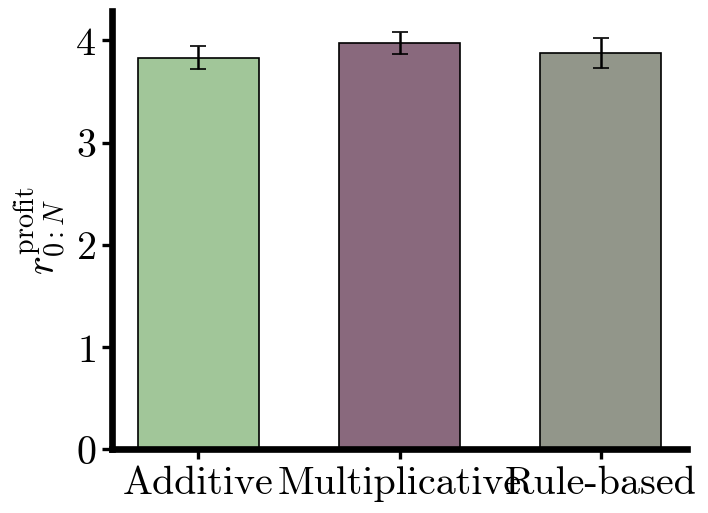

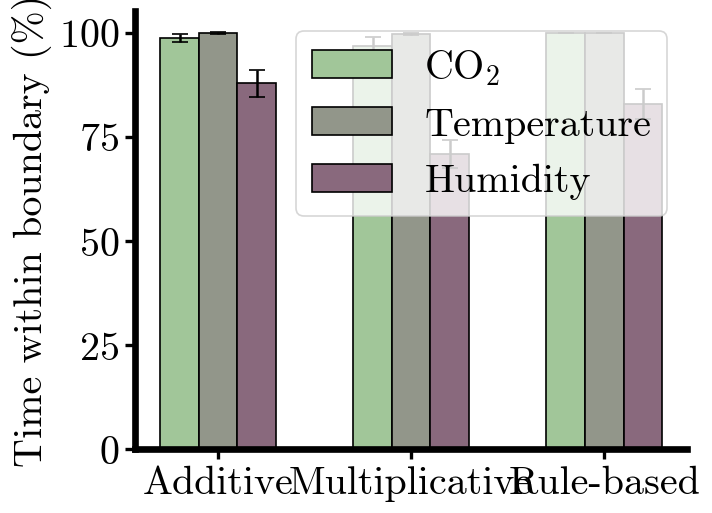

In [ ]:
# colors= [cm.tokyoS(4), cm.tokyoS(5), cm.tokyoS(6)]
# print(profits_per_episode[0].shape, profits_per_episode[1].shape)
colors = [cm.tokyoS(4), cm.tokyoS(6), cm.tokyoS(9)]
generate_barplots(profits_per_episode, xlabels,colors)
generate_grouped_bar_plot(twb_df, twb_df_ci, xlabels, colors)

In [ ]:
ttest_ind(profits_per_episode[0]['Profits'], profits_per_episode[1]['Profits'])

TtestResult(statistic=1.3113886424906491, pvalue=0.19227248327765928, df=118.0)

[3.829190369155922, 3.9721333826184666, 3.879761961004663] [0.11297450269485844, 0.10743501388682368, 0.14622269555227516]


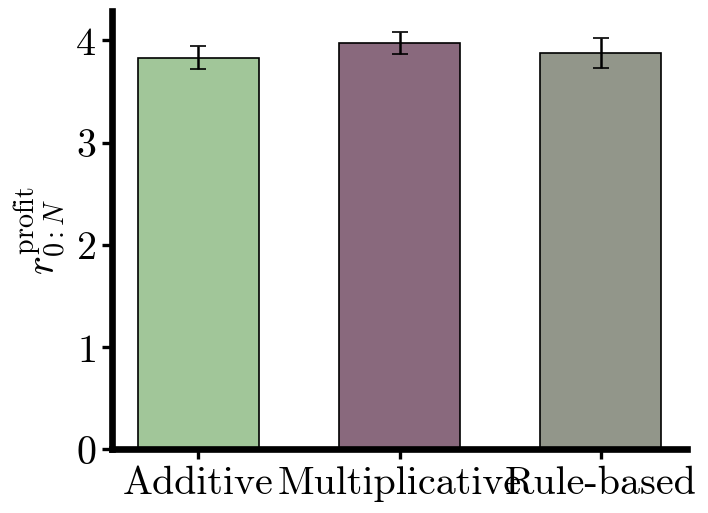

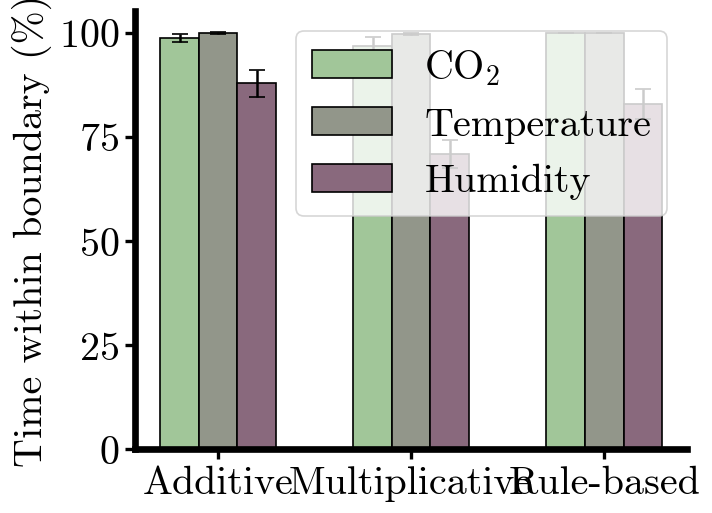

In [ ]:
# colors= [cm.tokyoS(4), cm.tokyoS(5), cm.tokyoS(6)]
# print(profits_per_episode[0].shape, profits_per_episode[1].shape)
colors = [cm.tokyoS(4), cm.tokyoS(6), cm.tokyoS(9)]
generate_barplots(profits_per_episode, xlabels,colors)
generate_grouped_bar_plot(twb_df, twb_df_ci, xlabels, colors)

In [19]:
twb_df, twb_df_ci

(                CO2 violation  Temperature violation  Humidity violation
 Additive            98.701389              99.851852           87.858796
 Multiplicative      96.782986              99.682870           70.901620
 Rule-based          99.938657              99.956308           84.099826,
                 CO2 violation  Temperature violation  Humidity violation
 Additive             0.934786               0.257633            3.198878
 Multiplicative       2.153122               0.306253            3.431571
 Rule-based           0.080542               0.081093            3.274471)

In [ ]:
twb_df

,CO2 violation,Temperature violation,Humidity violation
Additive,98.701389,99.851852,87.858796
Multiplicative,96.782986,99.682870,70.901620
Rule-based,99.940972,99.974537,82.937500


In [ ]:
twb_df_ci


,CO2 violation,Temperature violation,Humidity violation
Additive,0.934786,0.257633,3.198878
Multiplicative,2.153122,0.306253,3.431571
Rule-based,0.093043,0.056684,3.542609


0.2561551349464359
0.25661656214864836
0.26912746541713334


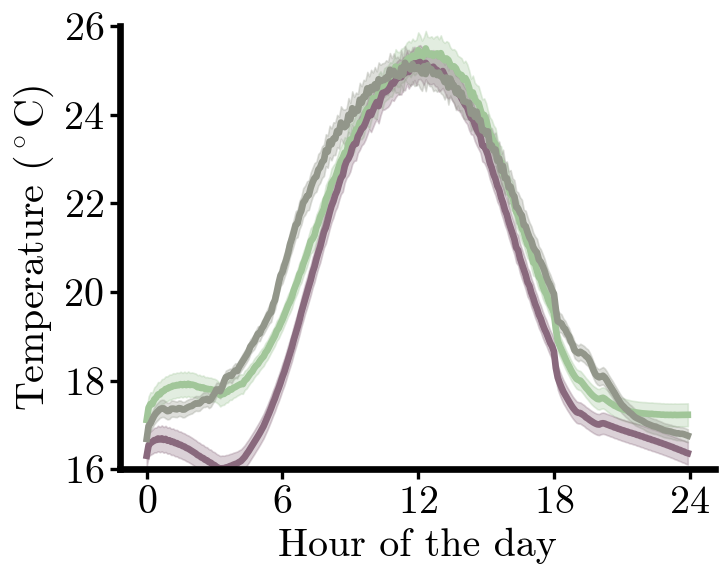

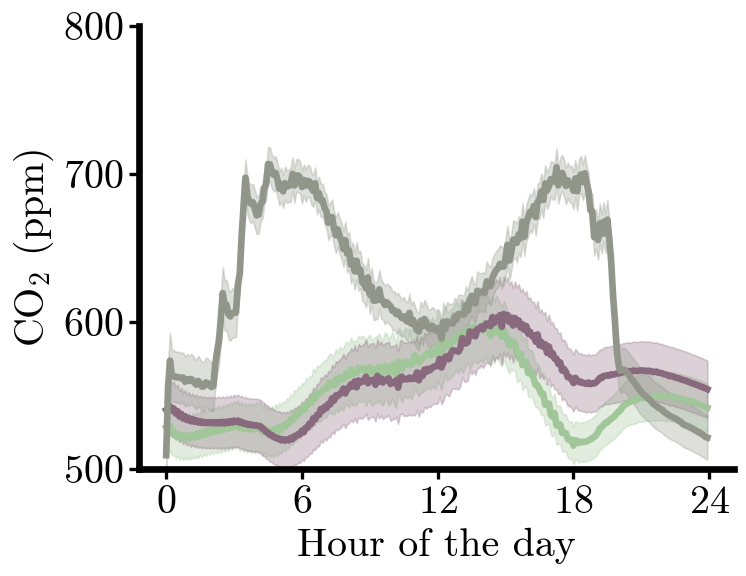

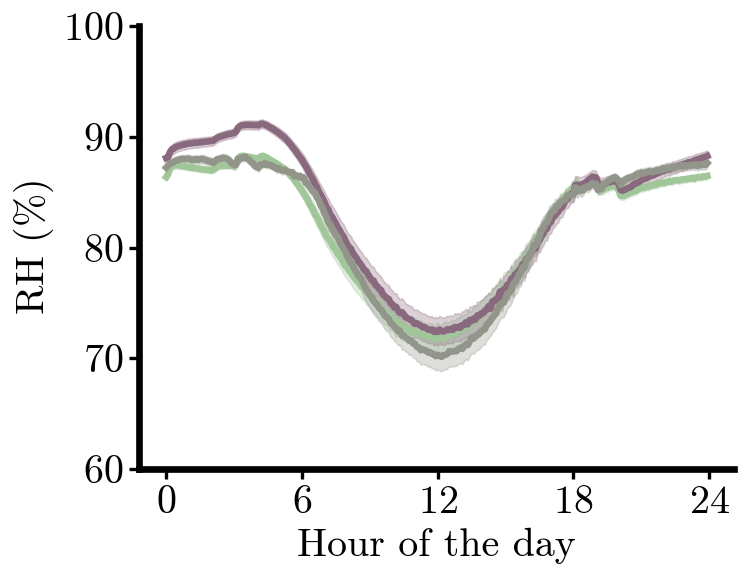

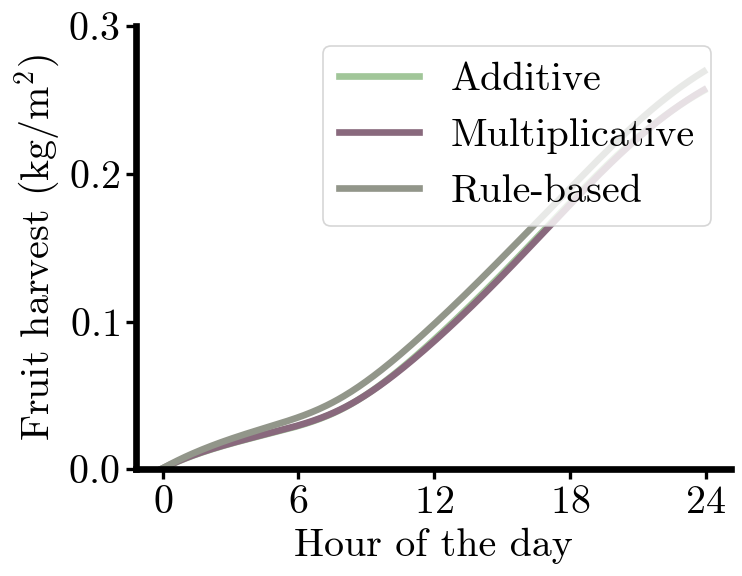

In [ ]:
state_variables = ['Air Temperature', 'CO2 concentration', 'Humidity', 'Fruit harvest FW']
labels = ['Additive', 'Multiplicative', 'Rule-based']
ylabels = [r'Temperature ($^\circ$C)', '$\mathrm{CO_2}$ (ppm)', '$\mathrm{RH}}$ (%)', 'Fruit harvest (kg/m$^2$)']
ylim = [(16, 26), (500, 800), (60, 100), (0, 0.3)]
for i, variable in enumerate(state_variables):
    fig, ax = plt.subplots(dpi=120)
    if 'Fruit' in variable:
        plot_avg_day(dfs[0], variable, fig, ax, labels[0], '-', colors[0], cumsum=True)
        plot_avg_day(dfs[1], variable, fig, ax, labels[1], '-', colors[1], cumsum=True)
        plot_avg_day(dfs[2], variable, fig, ax, labels[2], '-', colors[2], cumsum=True)
    else:
        plot_avg_day(dfs[0], variable, fig, ax, labels[0], '-', colors[0])
        plot_avg_day(dfs[1], variable, fig, ax, labels[1], '-', colors[1])
        plot_avg_day(dfs[2], variable, fig, ax, labels[2], '-', colors[2])
    ax.set_ylabel(ylabels[i])
    ax.set_ylim(ylim[i])
    fig.savefig(f'../figures/24h-mean-{variable}-2.svg', format='svg')
ax.legend()

fig.savefig(f'../figures/24h-mean-{variable}-2.svg', format='svg')


In [ ]:
rlhar = 0.25661656214864836
rbhar = 0.26912746541713334
rbhar-rlhar

0.012510903268484974

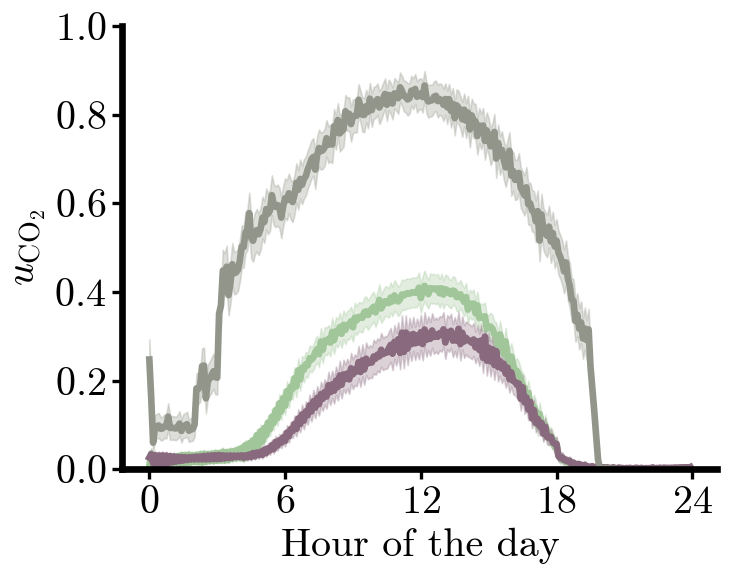

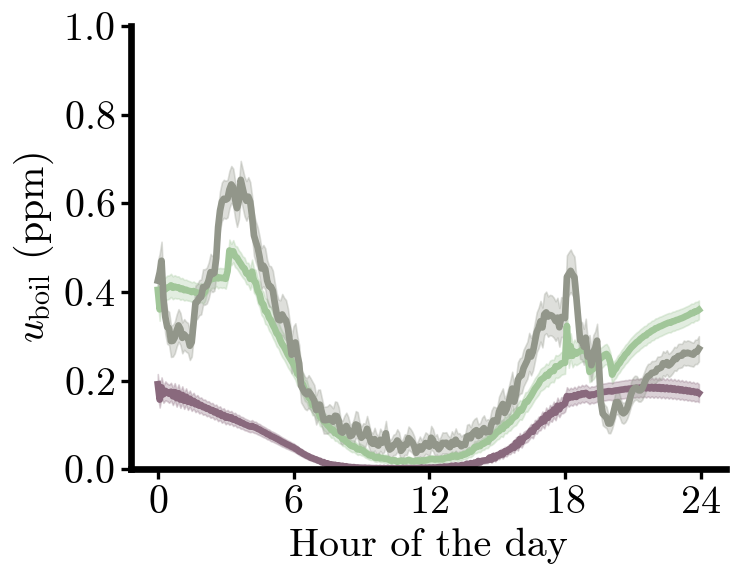

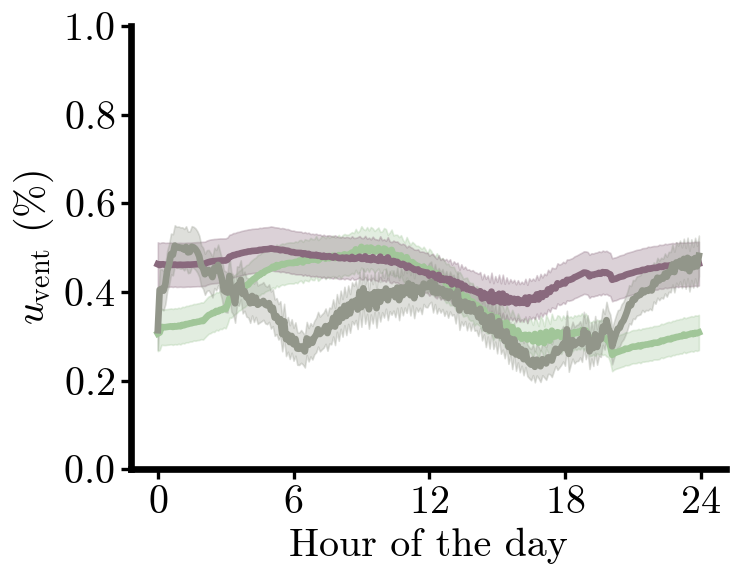

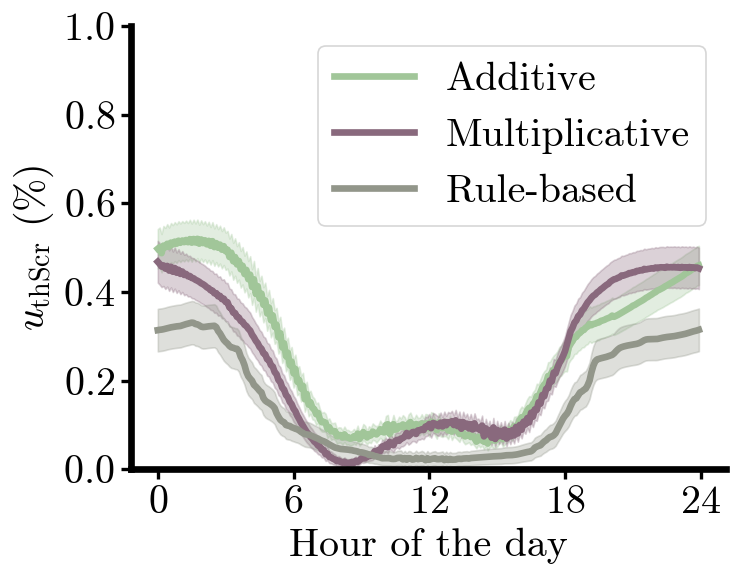

In [ ]:
control_variables= ['uCO2', 'uBoil', 'uVent', 'uThScr']
labels = ['Additive', 'Multiplicative', 'Rule-based']
ylabels = ['$u_{\mathrm{CO_2}}$', '$u_{\mathrm{boil}}$ (ppm)', '$u_{\mathrm{vent}}$ (%)', '$u_{\mathrm{thScr}}$ (%)']
for i, variable in enumerate(control_variables):
    fig, ax = plt.subplots(dpi=120)
    plot_avg_day(dfs[0], variable, fig, ax, labels[0], '-', colors[0])
    plot_avg_day(dfs[1], variable, fig, ax, labels[1], '-', colors[1])
    plot_avg_day(dfs[2], variable, fig, ax, labels[2], '-', colors[2])
    ax.set_ylabel(ylabels[i])
    ax.set_ylim(0, 1)
    fig.savefig(f'../figures/24h-mean-{variable}-2.svg', format='svg')
ax.legend()
fig.savefig(f'../figures/24h-mean-{variable}-2.svg', format='svg')


In [ ]:
def calc_svp(temp):
    return 610.78*np.exp(17.2694*temp/(temp+238.3))


def calc_vpd(svp, rh):
    return svp * (1 - rh/100)

def sort_runs_by_profit(profits_per_episode):
    return [df.sort_values(by='Profits', ascending=False) for df in profits_per_episode]

In [ ]:
def compute_seasonal_profits(df):
    df['Date'] = pd.to_datetime(df['Time'])
    df['Month'] = df['Date'].dt.month
    # convert numeric months to string
    df['Cumulative profit'] = df.groupby('episode')['Profits'].cumsum()

    # extract final profit for each episode
    final_profits = df.groupby('episode')[['Cumulative profit', 'Month', 'Date']].last().reset_index()
    
    seasonal_profits = final_profits.groupby(['Month'])['Cumulative profit'].mean()
    # print(seasonal_profits)
    seasonal_std = final_profits.groupby(['Month'])['Cumulative profit'].std()
    seasonality = pd.DataFrame({'Mean': seasonal_profits, 'Std': seasonal_std})

    # seasonality.reset_index(inplace=True, drop=False)
    # convert month column as string type

    seasonality.reset_index(inplace=True, drop=False)
    seasonality['Month'] = pd.to_datetime(seasonality['Month'], format='%m').dt.month_name().str.slice(stop=3)
    return seasonality


In [ ]:
seasonality = compute_seasonal_profits(dfs[0])
seasonality_rb = compute_seasonal_profits(dfs[1])


In [ ]:
seasonality

,Month,Mean,Std
0,Mar,3.975906,0.258275
1,Apr,4.027985,0.133082
2,May,4.138973,0.269186
3,Jun,4.236836,0.173550
4,Jul,3.806521,0.346994
5,Aug,3.646579,0.340973


In [ ]:
seasonality_rb

,Month,Mean,Std
0,Mar,3.598957,0.222930
1,Apr,3.943489,0.147600
2,May,4.208368,0.242990
3,Jun,4.204615,0.273085
4,Jul,3.631193,0.607016
5,Aug,3.691951,0.506538


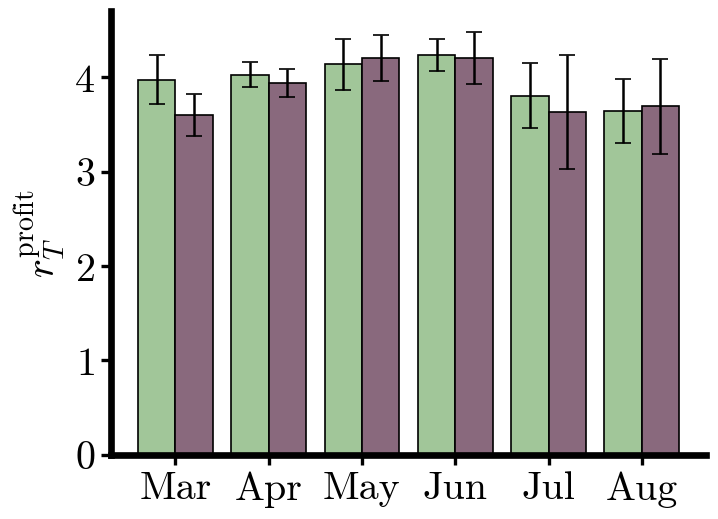

In [ ]:


fig, ax = plt.subplots(dpi=120)
bar_width = 0.4
ax.bar(seasonality.index-bar_width/2, seasonality['Mean'], yerr=seasonality['Std'], width=bar_width, capsize=5, color=colors[0], label='RL', edgecolor='black')
ax.bar(seasonality_rb.index+bar_width/2, seasonality_rb['Mean'], yerr=seasonality_rb['Std'], width=bar_width, capsize=5, color=colors[1], label='Rule-based', edgecolor='black')

ax.set_ylabel(r'$r_{T}^{\mathrm{profit}}$')
# set xticks to month
ax.set_xticks(seasonality.index)
ax.set_xticklabels(seasonality['Month'], ha='center')




# ax.legend()
# create a list of months
fig.savefig('../figures/seasonal-profits.svg', format='svg')


In [ ]:
sorted_multi  = profits_per_episode[0].sort_values(by='Profits', ascending=False)
sorted_rb  = profits_per_episode[1].sort_values(by='Profits', ascending=False)

sorted_multi#

,episode,Profits
27,27,4.569951
35,35,4.531495
30,30,4.434738
20,20,4.431378
25,25,4.340766
5,5,4.331140
34,34,4.295953
36,36,4.295446
28,28,4.288651
12,12,4.267269


In [ ]:
sorted_rb

,episode,Profits
30,30,4.590425
34,34,4.515496
27,27,4.507099
25,25,4.443677
31,31,4.421208
20,20,4.402171
28,28,4.390515
38,38,4.377487
35,35,4.294481
43,43,4.271248


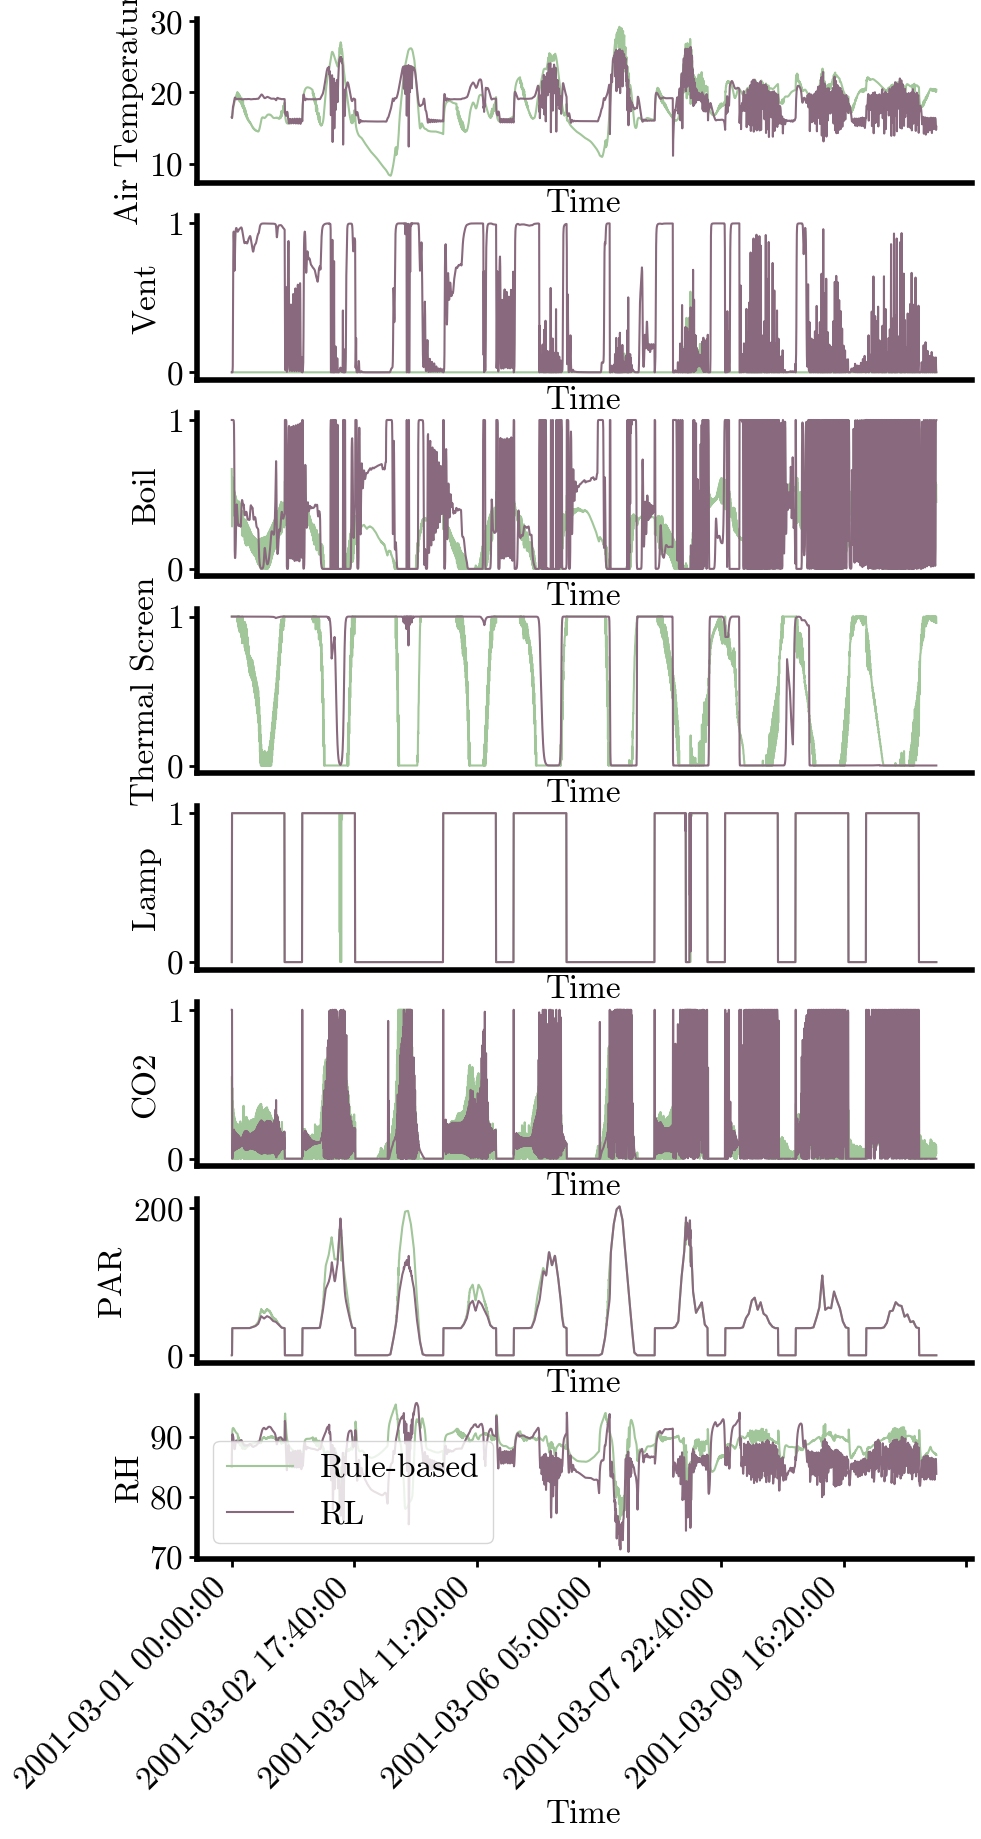

In [ ]:
episode = 0

rl_df = dfs[0]
rb_df = dfs[1]

fig = plt.figure(figsize=(10, 20))
ax1 = fig.add_subplot(811)
ax2 = fig.add_subplot(812)
ax3 = fig.add_subplot(813)
ax4 = fig.add_subplot(814)
ax5 = fig.add_subplot(815)
ax6 = fig.add_subplot(816)
ax7 = fig.add_subplot(817)
ax8 = fig.add_subplot(818)

rl_df[rl_df['episode'] == episode].plot(x='Time', y='Air Temperature', kind='line', color=colors[0], ax=ax1, label='RL')
rb_df[rb_df['episode'] == episode].plot(x='Time', y='Air Temperature', kind='line', color=colors[1], ax=ax1, label='Rule-based')
ax1.set_ylabel('Air Temperature')

rl_df[rl_df['episode'] == episode].plot(x='Time', y='uVent', kind='line', color=colors[0], ax=ax2, label='RL')
rb_df[rb_df['episode'] == episode].plot(x='Time', y='uVent', kind='line', color=colors[1], ax=ax2, label='Rule-based')
ax2.set_ylabel('Vent')

rl_df[rl_df['episode'] == episode].plot(x='Time', y='uBoil', kind='line', color=colors[0], ax=ax3, label='RL')
rb_df[rb_df['episode'] == episode].plot(x='Time', y='uBoil', kind='line', color=colors[1], ax=ax3, label='Rule-based')
ax3.set_ylabel('Boil')

rl_df[rl_df['episode'] == episode].plot(x='Time', y='uThScr', kind='line', color=colors[0], ax=ax4, label='RL')
rb_df[rb_df['episode'] == episode].plot(x='Time', y='uThScr', kind='line', color=colors[1], ax=ax4, label='Rule-based')
ax4.set_ylabel('Thermal Screen')

rl_df[rl_df['episode'] == episode].plot(x='Time', y='uLamp', kind='line', color=colors[0], ax=ax5, label='RL')
rb_df[rb_df['episode'] == episode].plot(x='Time', y='uLamp', kind='line', color=colors[1], ax=ax5, label='Rule-based')
ax5.set_ylabel('Lamp')


rl_df[rl_df['episode'] == episode].plot(x='Time', y='uCO2', kind='line', color=colors[0], ax=ax6, label='RL')
rb_df[rb_df['episode'] == episode].plot(x='Time', y='uCO2', kind='line', color=colors[1], ax=ax6, label='Rule-based')
ax6.set_ylabel('CO2')

rl_df[rl_df['episode'] == episode].plot(x='Time', y='PAR', kind='line', color=colors[0], ax=ax7, label='RL')
rb_df[rb_df['episode'] == episode].plot(x='Time', y='PAR', kind='line', color=colors[1], ax=ax7, label='Rule-based')
ax7.set_ylabel('PAR')


rl_df[rl_df['episode'] == episode].plot(x='Time', y='Humidity', kind='line', color=colors[0], ax=ax8, label='Rule-based')
rb_df[rb_df['episode'] == episode].plot(x='Time', y='Humidity', kind='line', color=colors[1], ax=ax8, label='RL')
ax8.set_ylabel('RH')


# rl_df[rl_df['episode'] == episode].plot(x='Time', y='uCO2', kind='line', color=colors[0], ax=ax6, label='Rule-based')
# rb_df[rb_df['episode'] == episode].plot(x='Time', y='uCO2', kind='line', color=colors[0], ax=ax6, label='RL')

# remove x ticks from axis
ax1.set_xticks([])
ax2.set_xticks([])
ax3.set_xticks([])
ax4.set_xticks([])
ax5.set_xticks([])
ax6.set_xticks([])
ax7.set_xticks([])
# skip legend
ax1.legend().remove()
ax2.legend().remove()
ax3.legend().remove()
ax4.legend().remove()
ax5.legend().remove()
ax6.legend().remove()
ax7.legend().remove()
# ax8.legend().remove()

# rotate x labels
ax8.set_xticklabels(ax8.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()
# rl_df[rl_df['episode'] == episode].plot(x='Time', y='Air Temperature', kind='scatter', colormap='viridis', c=rl_df[rl_df['episode'] == episode]['Fruit harvest norm'], ax=ax)
# rb_df[rb_df['episode'] == episode].plot(x='Time', y='Fruit weight', kind='scatter', colormap='viridis', c=rb_df[rb_df['episode'] == episode]['Fruit harvest norm'], ax=ax)


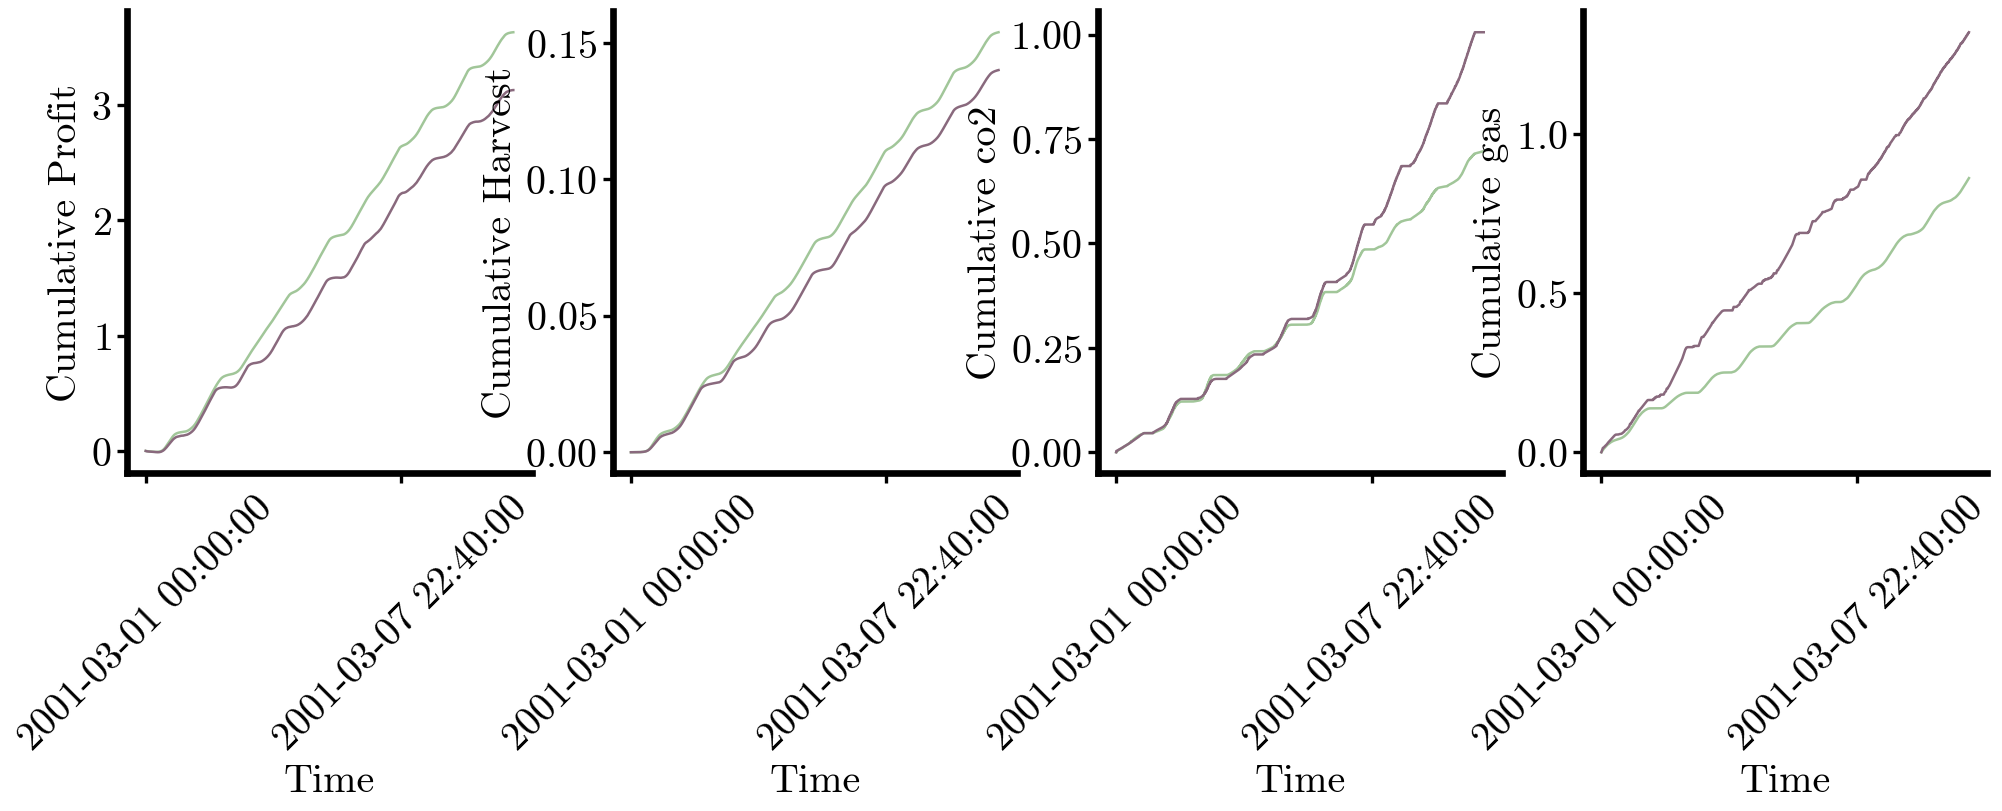

In [ ]:
fig, axes = plt.subplots(1,4 , figsize=(20, 5), dpi=120)
rb_df['Cumulative Profit'] = rb_df.groupby('episode')['Profits'].cumsum()
rl_df['Cumulative Profit'] = rl_df.groupby('episode')['Profits'].cumsum()

rb_df['Cumulative Harvest'] = rb_df.groupby('episode')['Fruit harvest'].cumsum()
rl_df['Cumulative Harvest'] = rl_df.groupby('episode')['Fruit harvest'].cumsum()

rb_df['Cumulative co2'] = rb_df.groupby('episode')['CO2 resource'].cumsum()
rl_df['Cumulative co2'] = rl_df.groupby('episode')['CO2 resource'].cumsum()

rb_df['Cumulative gas'] = rb_df.groupby('episode')['Gas resource'].cumsum()
rl_df['Cumulative gas'] = rl_df.groupby('episode')['Gas resource'].cumsum()


# episode=9

cumulatives = ['Cumulative Profit', 'Cumulative Harvest', 'Cumulative co2', 'Cumulative gas']

for i, cost in enumerate(cumulatives):
    rl_df[rl_df['episode'] == episode].plot(x='Time', y=cumulatives[i], kind='line', color=colors[0],ax=axes[i], label='RL')
    rb_df[rb_df['episode'] == episode].plot(x='Time', y=cumulatives[i], kind='line', color=colors[1], ax=axes[i], label='Rule-based')
    axes[i].set_ylabel(cost)
    axes[i].legend().remove()
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)



In [ ]:
rl_df[rl_df['Air Temperature'] <= 10]

rl_df[rl_df['Temperature violation'] > 0]


,Time,Air Temperature,CO2 concentration,Humidity,Fruit weight,Fruit harvest,PAR,Daily mean crop temperature,CO2 resource,Gas resource,...,Fruit harvest norm,Fruit harvest FW,Date,TimeOfDay,Month,Cumulative profit,Cumulative Profit,Cumulative Harvest,Cumulative co2,Cumulative gas
608,2001-03-03 02:40:00,10.044055,654.861328,87.301262,0.285701,0.000029,-1.916831e-06,17.039226,7.479662e-05,2.344159e-04,...,0.294779,0.000463,2001-03-03 02:40:00,02:40:00,3,0.643533,0.643533,0.027484,0.121805,1.780198e-01
609,2001-03-03 02:45:00,9.996584,650.139033,87.336243,0.285670,0.000028,-2.196674e-07,17.013859,2.353105e-06,2.333508e-04,...,0.286531,0.000450,2001-03-03 02:45:00,02:45:00,3,0.644163,0.644163,0.027512,0.121807,1.782532e-01
610,2001-03-03 02:50:00,9.948822,660.326600,87.372291,0.285640,0.000027,1.477510e-06,16.988422,1.107602e-04,2.265157e-04,...,0.278661,0.000437,2001-03-03 02:50:00,02:50:00,3,0.644785,0.644785,0.027539,0.121918,1.784797e-01
611,2001-03-03 02:55:00,9.901005,655.007994,87.407776,0.285611,0.000027,-1.411108e-06,16.962915,-1.192327e-11,2.279008e-04,...,0.271146,0.000426,2001-03-03 02:55:00,02:55:00,3,0.645379,0.645379,0.027566,0.121918,1.787076e-01
612,2001-03-03 03:00:00,9.852916,664.757441,87.444168,0.285582,0.000026,2.860966e-07,16.937340,1.093599e-04,2.200628e-04,...,0.263965,0.000414,2001-03-03 03:00:00,03:00:00,3,0.645967,0.645967,0.027592,0.122027,1.789276e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143558,2010-07-09 11:10:00,35.601276,369.541469,43.887036,0.285903,0.000035,2.626165e+02,24.477301,-1.108206e-11,3.824606e-12,...,0.354029,0.000556,2010-07-09 11:10:00,11:10:00,7,3.441183,3.441183,0.135157,0.086704,2.899110e-10
143559,2010-07-09 11:15:00,35.497742,370.391628,43.830101,0.285881,0.000034,2.592223e+02,24.513756,-1.098865e-11,-1.483446e-12,...,0.346672,0.000544,2010-07-09 11:15:00,11:15:00,7,3.442037,3.442037,0.135191,0.086704,2.884275e-10
143560,2010-07-09 11:20:00,35.391548,370.721737,44.044618,0.285860,0.000033,2.533595e+02,24.549566,4.323406e-12,3.895602e-12,...,0.339858,0.000533,2010-07-09 11:20:00,11:20:00,7,3.442874,3.442874,0.135225,0.086704,2.923231e-10
143561,2010-07-09 11:25:00,35.288383,371.412662,44.078712,0.285840,0.000033,2.493411e+02,24.584808,9.653793e-12,-1.412297e-12,...,0.333547,0.000523,2010-07-09 11:25:00,11:25:00,7,3.443697,3.443697,0.135257,0.086704,2.909108e-10


NameError: name 'rb_df_profit' is not defined

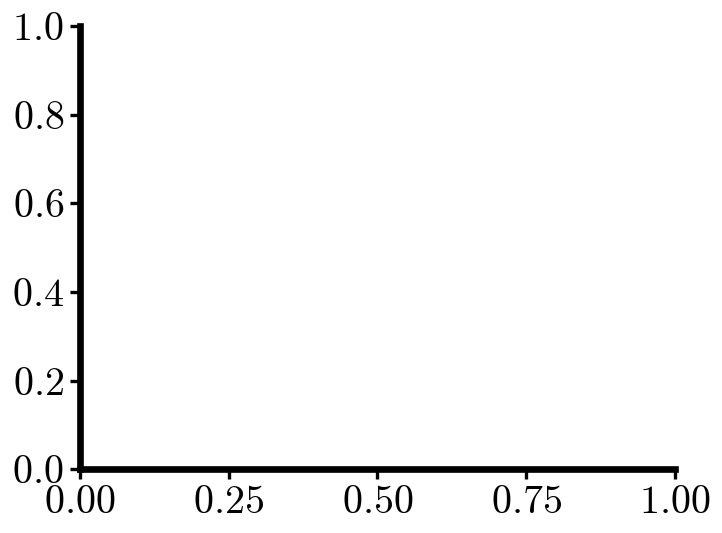

In [ ]:
# compute cumulative sum of harvest per episode
cumulative_harvest_rb = rb_df[['Fruit harvest', 'episode']].groupby('episode').sum().reset_index()
cumulative_harvest_rl = rl_df[['Fruit harvest', 'episode']].groupby('episode').sum().reset_index()

fig, ax = plt.subplots(dpi=120)
n = rb_df_profit.shape[0]
ax.plot(cumulative_harvest_rb['episode'], cumulative_harvest_rb['Fruit harvest'], label='Rule-based', color=tcolor)
ax.plot(cumulative_harvest_rl['episode'], cumulative_harvest_rl['Fruit harvest'], label='Rule-based', color=humcolor, linestyle='--')

<Axes: xlabel='Time', ylabel='PAR'>

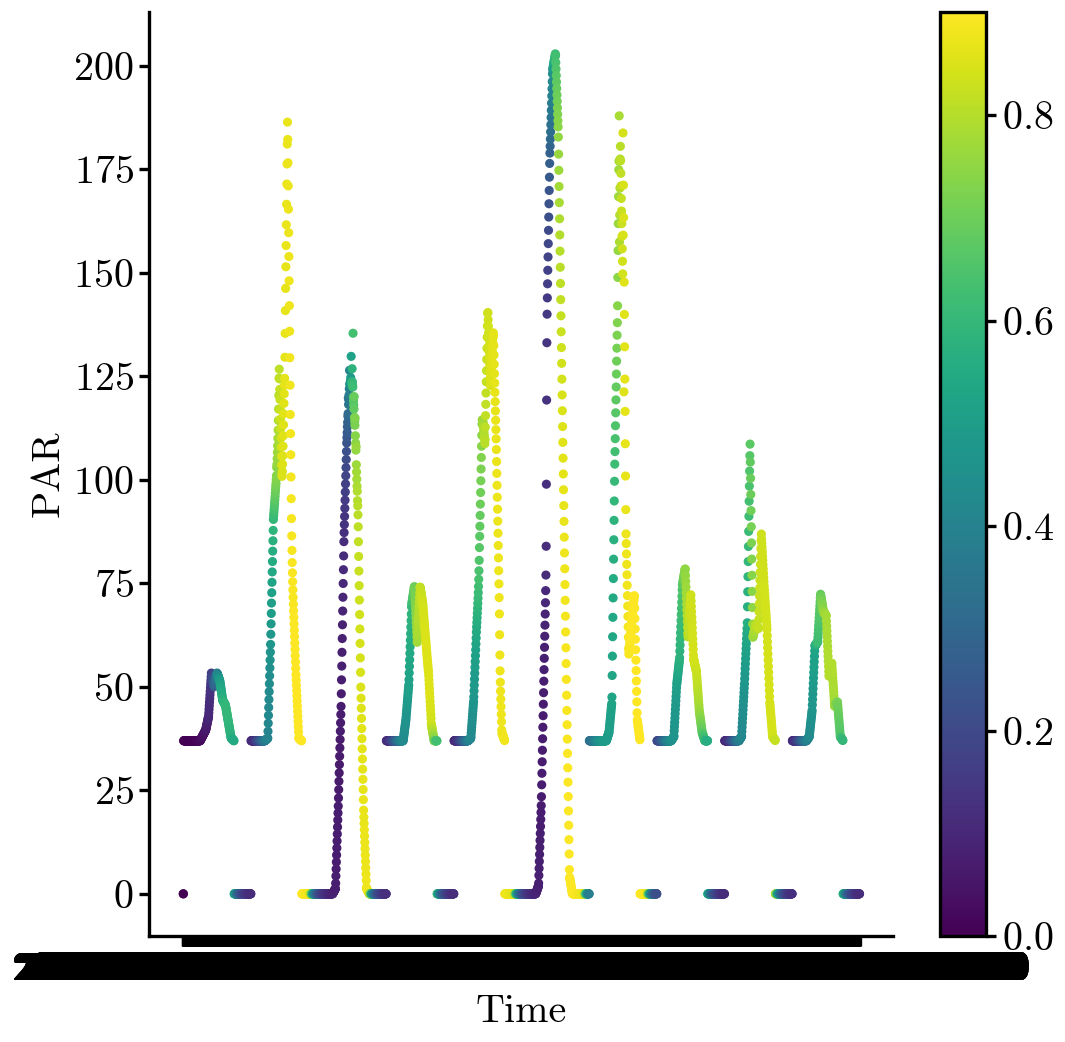

In [ ]:
episode = 0
fig, ax = plt.subplots(figsize=(10, 10), dpi=120)
rb_df[rb_df['episode'] == episode].plot(x='Time', y='PAR', kind='scatter', colormap='viridis', c=rb_df[rb_df['episode'] == episode]['Fruit harvest norm'], ax=ax)
# rl_df[rl_df['episode'] == episode].plot(x='Time', y='PAR', kind='scatter', colormap='viridis', c=rl_df[rl_df['episode'] == episode]['Fruit harvest norm'])


NameError: name 'df' is not defined

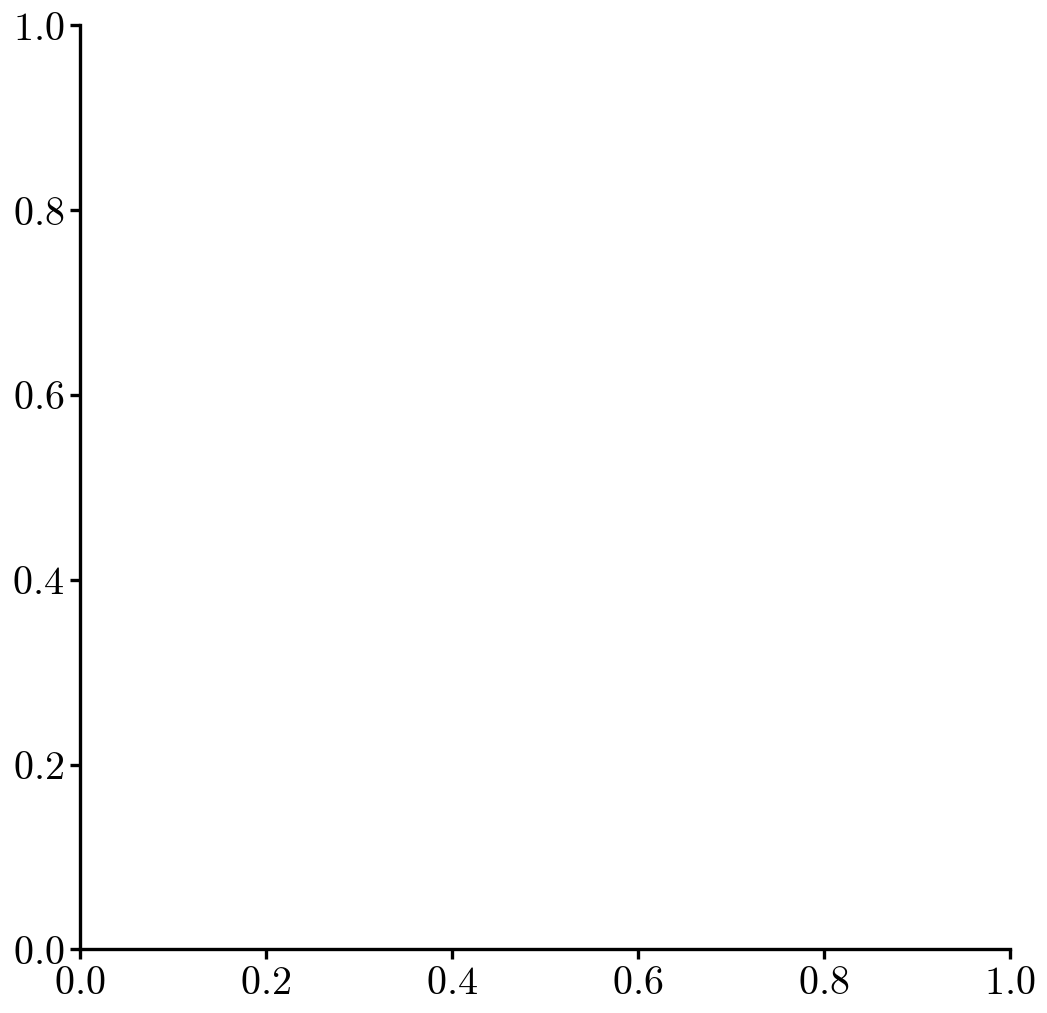

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=120)
df[df['episode'] == episode].plot(x='Time', y='uCO2', kind='scatter', colormap='viridis', c=df[df['episode'] == episode]['Fruit harvest norm'], ax=ax)
rl_df[rl_df['episode'] == episode].plot(x='Time', y='uCO2', kind='scatter', colormap='viridis', c=rl_df[rl_df['episode'] == episode]['Fruit harvest norm'])


(0.7, 1.0)

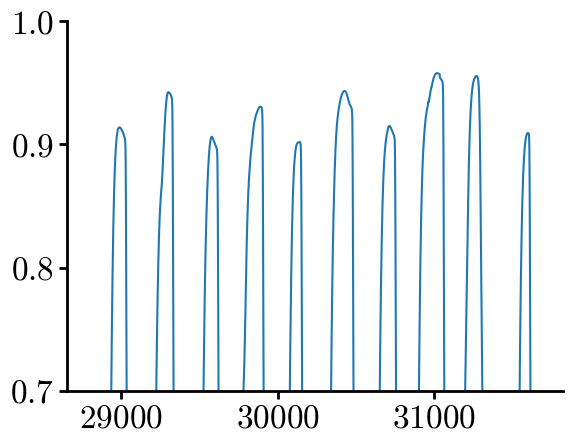

In [ ]:

plt.plot(df[df['episode'] == episode]['Fruit harvest norm'])

plt.ylim(0.7,1)
